## DIANNA demo with Imagenet

This notebook showcases the use of DIANNA on a Resnet network trained on a subset of the Imagenet dataset, containing 1000 categories.

#### Install and import packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

np.random.seed(42)

#### Define model and helper functions

In [2]:
class Model():
    def __init__(self):
        self.model = ResNet50()
        self.input_size = (224, 224)
        
    def run_on_batch(self, x):
        return self.model.predict(x)
    
model = Model()

2022-09-01 11:49:33.017837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def load_img(path):
    img = image.load_img(path, target_size=model.input_size)
    x = image.img_to_array(img)
    x = preprocess_input(x)
    return img, x

In [4]:
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

#### Run model on example data

(224, 224, 3)


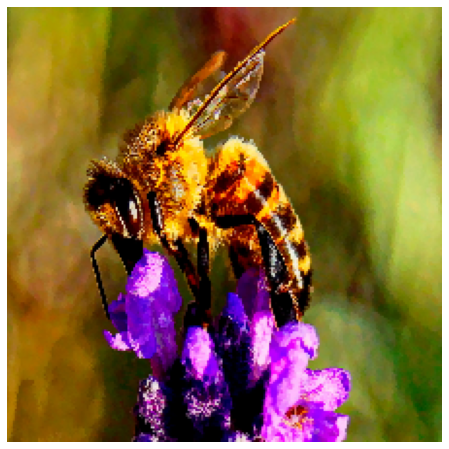

In [5]:
data_path = 'data/bee.jpg'
img, scaled_img = load_img(data_path)
print(scaled_img.shape)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off');

In [6]:
predictions = model.run_on_batch(np.expand_dims(scaled_img, 0))[0]
sorted_classes = np.argsort(predictions)[::-1]
print('\n'.join(['{:.4f} {:4} {}'.format(predictions[c], c, class_name(c)) for c in sorted_classes[:10]]))

1/1 [==============================] - 1s 811ms/step
0.9230  309 bee
0.0397  946 cardoon
0.0160  308 fly
0.0075  319 dragonfly
0.0054   74 garden_spider
0.0026  321 admiral
0.0018  324 cabbage_butterfly
0.0007  318 lacewing
0.0005  815 spider_web
0.0004  323 monarch


## Explainable AI with DIANNA

In [7]:
import dianna

In [8]:
axis_labels = {-1: 'channels'}  # the last axis contains the colour channels
labels = sorted_classes[:10]  # get an explanation for the top 10 labels
heatmaps = dianna.explain_image(model.run_on_batch, scaled_img, method='RISE',
                                axis_labels=axis_labels, labels=labels)

2/2 [==============================] - 2s 705ms/step
Rise parameter p_keep was automatically determined at 0.1


Explaining:   0%|                                        | 0/10 [00:00<?, ?it/s]

4/4 [==============================] - 4s 822ms/step


Explaining:  10%|███▏                            | 1/10 [00:03<00:33,  3.77s/it]

4/4 [==============================] - 4s 829ms/step


Explaining:  20%|██████▍                         | 2/10 [00:07<00:29,  3.72s/it]

4/4 [==============================] - 4s 838ms/step


Explaining:  30%|█████████▌                      | 3/10 [00:11<00:26,  3.73s/it]

4/4 [==============================] - 4s 838ms/step


Explaining:  40%|████████████▊                   | 4/10 [00:14<00:22,  3.74s/it]

4/4 [==============================] - 4s 854ms/step


Explaining:  50%|████████████████                | 5/10 [00:18<00:18,  3.76s/it]

4/4 [==============================] - 4s 854ms/step


Explaining:  60%|███████████████████▏            | 6/10 [00:22<00:15,  3.77s/it]

4/4 [==============================] - 5s 1s/step


Explaining:  70%|██████████████████████▍         | 7/10 [00:27<00:12,  4.12s/it]

4/4 [==============================] - 5s 1s/step


Explaining:  80%|█████████████████████████▌      | 8/10 [00:32<00:08,  4.30s/it]

4/4 [==============================] - 4s 1s/step


Explaining:  90%|████████████████████████████▊   | 9/10 [00:36<00:04,  4.36s/it]

4/4 [==============================] - 4s 920ms/step


Explaining: 100%|███████████████████████████████| 10/10 [00:40<00:00,  4.07s/it]


For each requested class (10 in this case), an explanation with a shape equal to the input image is generated:

In [9]:
print(heatmaps.shape)

(10, 224, 224)


The explanations can be considered images and can be plotted with e.g. `matplotlib`.  
DIANNA also includes visualization tools.  
In the plots generated by DIANNA, red means a pixel is in favour of the given class, while blue means it is against the given class.

In [10]:
from dianna.visualization import plot_image

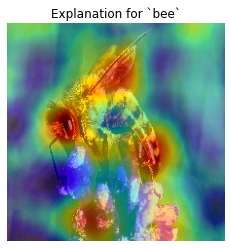

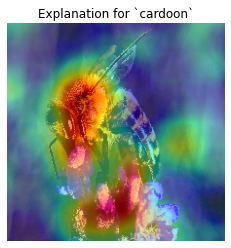

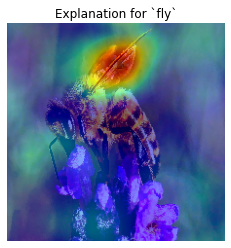

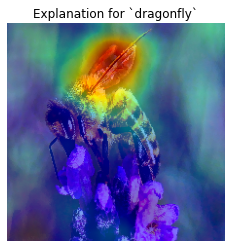

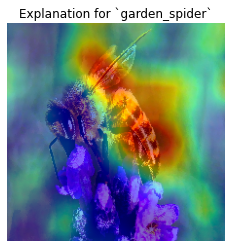

In [11]:
for idx, current_class_id in enumerate(sorted_classes[:5]):
    plot_image(heatmaps[idx], original_data=image.img_to_array(img)/255., heatmap_cmap='jet', show_plot=False)
    plt.title(f'Explanation for `{class_name(current_class_id)}`')
    plt.axis('off')

The top 5 results are all animals, except for the cardoon which is a type of plant. Let's look at that result a bit closer.

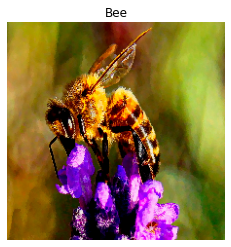

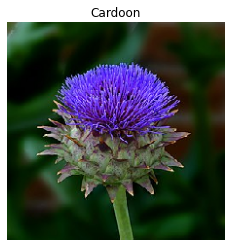

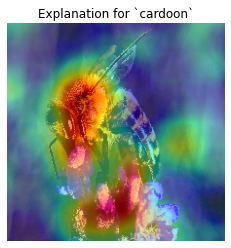

In [12]:
plt.imshow(img)
plt.title('Bee')
plt.axis('off')

plt.figure()
plt.imshow(load_img('data/cardoon.jpg')[0])
plt.title('Cardoon')
plt.axis('off')

idx = 1
plot_image(heatmaps[idx], original_data = image.img_to_array(img)/255., heatmap_cmap='jet', show_plot=False)
plt.title(f'Explanation for `{class_name(sorted_classes[idx])}`')
plt.axis('off');